## Imports

In [1]:
import io
import requests

from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.units import Quantity
import numpy as np
from astropy.utils.data import download_file
from astropy.nddata import Cutout2D
from astropy.coordinates import SkyCoord
from astropy.wcs import wcs
import astropy.io.fits as fits
from astropy.io.fits import getdata, getheader

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.colors import LogNorm

from rama import read, is_template, count, unroll
from rama.models.source import Source, SourcePosition, LuminosityMeasurement, Detection
from rama.models.coordinates import SpaceFrame
from rama.models.photdmalt import PhotometryFilter

# Suppress votable parse warnings.
import warnings
warnings.filterwarnings("ignore")

## Data Retrieval

In [2]:
def as_icrs_coord(c):
    if (type(c) is tuple or type(c) is list) and len(c) == 2:
        coords = parse_coordinates("{} {}".format(c[0], c[1]))
    elif type(c) is str:
        coords = parse_coordinates(coords)
    else:
        assert isinstance(c, SkyCoord), "ERROR: cannot parse input coordinates {}".format(c)
        coords = c
    icrs = coords.icrs
    return icrs

def vodml_query(base_url, params):
    #Send the request URL.
    response = requests.get(base_url, params=params)
    
    # Make additional file-like object so that the caller can parse it themsselves.
    xml = io.BytesIO(response.content)
    vodml = read(xml)
    
    return vodml

def cone_search(base_url, coord, radius):
    icrs = as_icrs_coord(coord)
    
    # Cone search params.
    params = {'RA': icrs.ra.deg, 'DEC': icrs.dec.deg, 'SR': radius}

    return vodml_query(base_url, params)

def hsc_matches(coord, radius):
    base_url = 'https://masttest.stsci.edu/vodml/Mashup/VoQuery.asmx/HscCone?'
    return cone_search(base_url, coord, radius)

def hsc_detections(match_id):
    val = scalar(match_id)
    match_id_str = val
    if not isinstance(val, str):
        match_id_str = f'{int(val)}'
        
    base_url = 'https://masttest.stsci.edu/vodml/Mashup/VoQuery.asmx/HscDetections?'
    params = {'MATCHID': match_id_str}
    return vodml_query(base_url, params)
            

## Source Utilities

In [3]:
def unrolled_instances(vodml, vodml_type):
    all_inst = vodml.find_instances(vodml_type)
    unrolled_list = []
    for inst in all_inst:
        if is_template(inst):
            unrolled = unroll(inst)
            unrolled_list.append(unrolled)
            
    return unrolled_list      

def scalar(q):
    val = q.value if isinstance(q, Quantity) else q
    return val

def get_luminosities(source):
    result = []
    for lm in source.luminosity:
        lm_value = scalar(lm.value)
        if lm_value and not np.isnan(lm_value):
            result.append(lm)
    return result
    
def get_mag_vals(source, band_name):
    mags = []
    for lm in get_luminosities(source):
        f = lm.filter
        if f.band_name == band_name:
            mags.append(scalar(lm.value))
    return mags

def find_bright_sources(inlist, band_name, cutoff):
    bright_sources = []
    bright_mags = []
    for s in inlist:
        mags = get_mag_vals(s, band_name)
        if mags:
            minval = np.min(mags)
            if minval <= cutoff:
                bright_sources.append(s)
                bright_mags.append(minval)

    return bright_sources, bright_mags


## HSC Matches Query

In [4]:
search_coord = SkyCoord.from_name("m82")
search_radius = 0.001 # degrees

match_vodml = hsc_matches(search_coord, search_radius)
matches = unrolled_instances(match_vodml, Source)[0]

match_table = list(match_vodml.tables.values())[0]

print(f'{len(match_table)} matches found.')

match_table.show_in_notebook()

19 matches found.


idx,MatchID,Distance,MatchRA,MatchDec,DSigma,AbsCorr,NumFilters,NumVisits,NumImages,StartMJD,StopMJD,TargetName,CI,CI_Sigma,KronRadius,KronRadius_Sigma,Extinction,SpectrumFlag,W2_F336W,W2_F336W_Sigma,W2_F336W_N,W2_F439W,W2_F439W_Sigma,W2_F439W_N,W2_F502N,W2_F502N_Sigma,W2_F502N_N,W2_F547M,W2_F547M_Sigma,W2_F547M_N,W2_F555W,W2_F555W_Sigma,W2_F555W_N,W2_F631N,W2_F631N_Sigma,W2_F631N_N,W2_F656N,W2_F656N_Sigma,W2_F656N_N,W2_F658N,W2_F658N_Sigma,W2_F658N_N,W2_F814W,W2_F814W_Sigma,W2_F814W_N,_selected_
,none,arcminutes,deg,deg,mas,,,,,days,days,,ABMAG,ABMAG,arcs,arcs,ABMAG,,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,ABMAG,
0,17350615.0,0.00883306720656974,148.96888203758,69.6797072526489,0.0,Y,1,1,1,54834.6258381181,54834.6575510763,NGC3034,3.03022225697835,0.0,0.349999994039536,0.0,0.153628796339035,N,21.7112998962402,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,--
1,17112744.0,0.0131180875647911,148.968997760412,69.6795900802937,24.9352755222915,Y,5,2,7,50523.2968749586,51053.1723864423,NGC3034-OUTFLOW,4.40160139654805,0.201972231036192,0.455,5.99588961666477e-17,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,19.6096000671387,0.0,1.0,19.1471004486084,0.0,1.0,nan,nan,0.0,18.4589004516602,0.0,1.0,16.551344871521,0.141215544746661,2.0,17.1591949462891,0.258807275140784,2.0,nan,nan,0.0,--
2,17115228.0,0.020600919203083,148.968682222876,69.6800372272498,0.0,N,2,1,2,50706.0557152592,50706.5385857429,NGC3034B-2,1.46466158982634,0.280854668066096,0.349999994039536,0.0,0.153628796339035,N,nan,nan,0.0,23.6833992004395,0.0,1.0,nan,nan,0.0,nan,nan,0.0,21.4559001922607,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,--
3,17111544.0,0.0303987662778864,148.967404818518,69.6793523018495,0.0,Y,1,1,1,51053.0043308656,51053.0177567475,NGC3034-OUTFLOW,0.893353515521277,0.0,0.455,0.0,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,19.2964992523193,0.0,1.0,nan,nan,0.0,nan,nan,0.0,--
4,17109683.0,0.0319055670213261,148.968358648006,69.6802334322381,0.0,N,3,1,3,50706.0557152592,50706.5385857429,NGC3034B-2,2.09449786486391,0.388645102107531,0.349999994039536,0.0,0.153628796339035,N,nan,nan,0.0,22.9946994781494,0.0,1.0,nan,nan,0.0,nan,nan,0.0,20.3750991821289,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,18.8915004730225,0.0,1.0,--
5,17114183.0,0.032588602427965,148.96711764508,69.6794230683398,0.0,Y,2,1,2,51053.0043308656,51053.0362752476,NGC3034-OUTFLOW,1.90672206374454,0.115679347320594,0.455,0.0,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,18.8257007598877,0.0,1.0,19.4087009429932,0.0,1.0,nan,nan,0.0,--
6,17113460.0,0.0345891900125784,148.967783047583,69.6802294411111,0.0,N,2,1,2,50706.0557152592,50706.411270882,NGC3034B-2,1.49194795240549,0.305330827860097,0.349999994039536,0.0,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,20.3157997131348,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,18.3355007171631,0.0,1.0,--
7,17114343.0,0.0348678278920604,148.96909172414,69.6791649101117,0.0,Y,1,1,1,54834.6258381181,54834.6575510763,NGC3034,2.26777765485975,0.0,0.349999994039536,0.0,0.153628796339035,N,20.3945007324219,0.0,1.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,--
8,17111787.0,0.0363046062064173,148.968825628571,69.6802942781797,124.635228628899,Y,5,2,5,50706.0557152592,51053.1723864423,NGC3034B-2,2.43431607887766,0.195207045634591,0.433999998807907,0.0469574301930963,0.153628796339035,N,nan,nan,0.0,nan,nan,0.0,nan,nan,0.0,20.5723991394043,0.0,1.0,21.6469993591309,0.0,1.0,19.9225006103516,0.0,1.0,16.6112003326416,0.0,1.0,17.3407001495361,0.0,1.0,nan,nan,0.0,--


In [5]:
for i, s in enumerate(matches):
    print(f'{match_table[i]["MatchID"]}, {match_table[i]["NumImages"]}, {len(get_luminosities(s))}')

17350615.0 none, 1, 1
17112744.0 none, 7, 5
17115228.0 none, 2, 2
17111544.0 none, 1, 1
17109683.0 none, 3, 3
17114183.0 none, 2, 2
17113460.0 none, 2, 2
17114343.0 none, 1, 1
17111787.0 none, 5, 5
17113463.0 none, 4, 4
17113661.0 none, 1, 1
17350576.0 none, 1, 1
17111042.0 none, 1, 1
17115009.0 none, 1, 1
17115007.0 none, 2, 2
17111068.0 none, 3, 3
17115017.0 none, 6, 4
17110937.0 none, 1, 1
17115272.0 none, 1, 1


### Find a bright-ish source with multiple luminosties.

In [6]:
bright_sources, b_mags = find_bright_sources(matches, 'B', 23)
bs_multi = None
brightest = 30
for i, s in enumerate(bright_sources):
    #print(f'Source {int(scalar(s.name))} has b_mag = {b_mags[i]}')
    #print(f'{match_table[i]["MatchID"]}, {match_table[i]["NumImages"]}, {len(get_luminosities(s))}')
    
    # Save a bright-ish source with multiple luminosities.
    if len(get_luminosities(s)) > 1 and b_mags[i] < brightest:
        bs_multi = s
        brightest = b_mags[i]
        
print(f'Bright source {int(scalar(bs_multi.name))} ({brightest}) has {len(get_luminosities(bs_multi))} luminosities.')

Bright source 17111068 (22.0561008453369) has 3 luminosities.


### Load detections for "bright" multi-image source

In [7]:
# Load the detections for that "bright" source.
det_vodml = hsc_detections(bs_multi.name)
detections = unrolled_instances(det_vodml, Detection)[0]

det_table = list(det_vodml.tables.values())[0]
print(f'{len(det_table)} detections found.')

det_table.show_in_notebook()

3 detections found.


idx,CatID,MatchID,MemID,SourceID,ImageID,Det,MatchRA,MatchDec,SourceRA,SourceDec,D,DSigma,AbsCorr,XImage,YImage,ImageName,Instrument,Mode,Detector,Aperture,ExposureTime,StartMJD,StopMJD,WaveLength,Filter,TargetName,FluxAper2,MagAper2,MagAuto,PropID,CI,KronRadius,Flags,naxis,crpix,crval,cd_matrix,_selected_,AccessUrlFits
,,,,none,none,,deg,deg,deg,deg,mas,,,,,,,,,,s,days,days,,,,counts/s,ABMAG,ABMAG,none,ABMAG,arcs,none,,,,,,
0,266244160,17111068,1,4662322208.0,550998.0,Y,148.967691997043,69.6806162425154,148.967691997043,69.6806162425154,0.0,0.0,N,1629.1689453125,1275.83605957031,hst_07446_01_wfpc2_f439w_wf,WFPC2,IMAGE,WFPC2,PC1-FIX,8500.0,50706.1911319606,50706.5385857429,4311.0,F439W,NGC3034B-2,2.12998008728027,22.0561008453369,21.0736999511719,7446.0,2.4076405535923,0.349999994039536,1.0,2250 2250,1125.00 1125.00,149.00802146 69.67643030,-2.77778e-005 1.23286e-009 1.23286e-009 2.77778e-005,--,https://hla.stsci.edu/cgi-bin/fitscut.cgi?config=hscv2&red=hst_07446_01_wfpc2_f439w_wf&size=ALL&format=fits
1,268050952,17111068,2,4662322208.0,550998.0,Y,148.967691997043,69.6806162425154,148.967691997043,69.6806162425154,0.0,0.0,N,1629.1689453125,1275.83605957031,hst_07446_01_wfpc2_f555w_wf,WFPC2,IMAGE,WFPC2,PC1-FIX,5600.0,50706.0557152592,50706.3450671737,5439.0,F555W,NGC3034B-2,68.8655014038086,20.0942993164063,19.5186004638672,7446.0,2.24976747534996,0.349999994039536,1.0,2250 2250,1125.00 1125.00,149.00802146 69.67643030,-2.77778e-005 1.23286e-009 1.23286e-009 2.77778e-005,--,https://hla.stsci.edu/cgi-bin/fitscut.cgi?config=hscv2&red=hst_07446_01_wfpc2_f555w_wf&size=ALL&format=fits
2,257567336,17111068,3,4662322208.0,550998.0,Y,148.967691997043,69.6806162425154,148.967691997043,69.6806162425154,0.0,0.0,N,1629.1689453125,1275.83605957031,hst_07446_01_wfpc2_f814w_wf,WFPC2,IMAGE,WFPC2,PC1-FIX,4400.0,50706.125854169,50706.411270882,8012.0,F814W,NGC3034B-2,173.139999389648,18.6145992279053,19.6951999664307,7446.0,1.93096771035143,0.349999994039536,1.0,2250 2250,1125.00 1125.00,149.00802146 69.67643030,-2.77778e-005 1.23286e-009 1.23286e-009 2.77778e-005,--,https://hla.stsci.edu/cgi-bin/fitscut.cgi?config=hscv2&red=hst_07446_01_wfpc2_f814w_wf&size=ALL&format=fits


### Dowload detection images

In [8]:
det_image_files = [None] * len(detections)
for i, det in enumerate(detections):
    access_url = det.source_image[0].url
    det_image_files[i] = download_file(access_url, cache=True )
    

### Plot cutouts of the detection from each image.

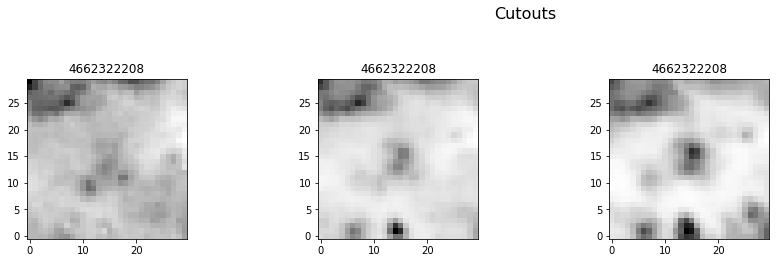

In [9]:
#Set up the figure.
fig = plt.figure(figsize=(20,10))
plt.suptitle('Cutouts', fontsize=16)

for i, filename in enumerate(det_image_files):
    #Make the title be the name of the detection.
    det = detections[i]
    title = int(scalar(det.name))
    ra = det.position[0].coord.icrs.ra.deg
    dec = det.position[0].coord.icrs.dec.deg
    
    # Plot the first image data we find.
    hdu_list = fits.open(filename)
    for hdu_idx in range(len(hdu_list)):
        h = hdu_list[hdu_idx].header
        prime_or_image = (hdu_idx == 0) or (h.get('XTENSION') == 'IMAGE')
        is_image = (h.get('NAXIS') == 2) and prime_or_image
        if (is_image):
            break
            
    #Read in the image, header, and WCS
    data = getdata(filename, hdu_idx)
    header = getheader(filename, hdu_idx)
    w = wcs.WCS(header)

    #Make a cutout centered on the detection.
    position = SkyCoord(ra, dec, unit = 'deg')
    size = 30.0 #* u.arcsec
    cutout = Cutout2D(data, position, (size, size), wcs=w)

    #Make a subplot for this image.
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(cutout.data, cmap='gray_r', origin='lower')
    ax.set_title(title)